# Corporate credit card transactions published by the London Borough of Barnet analysis and anamoly detection - Mamta Tomar

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.ensemble import IsolationForest
warnings.filterwarnings("ignore")

# Importing datasets

In [2]:
# first importing the first dataset Purchasing Card Data 2014

df_2014 = pd.read_csv('/Users/mamta/Downloads/Purchasing Card Data 2014.csv')
df_2014.head()

,Service Area,Account Description,Creditor,Transaction Date,JV Reference,JV Date,JV Value
0,Childrens Services,IT Services,123-REG.CO.UK,23/04/2014,93,20/05/2014,143.81
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,03/04/2014,111,20/05/2014,"6,000.00"
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,6,20/05/2014,309.38
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,7,20/05/2014,218.76
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,15/04/2014,381,20/05/2014,306


In [3]:
# drop JV Date column
df_2014 = df_2014.drop('JV Date', axis = 1)

# Rename columns name JV Value to Total, JV Reference to Journal Reference, and Transaction Date to Journal Date
df_2014.rename(columns={"JV Value": "Total"}, inplace='True')
df_2014.rename(columns={"JV Reference": "Journal Reference"}, inplace='True')
df_2014.rename(columns={"Transaction Date":"Journal Date"}, inplace='True')

df_2014.head()

,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total
0,Childrens Services,IT Services,123-REG.CO.UK,23/04/2014,93,143.81
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,03/04/2014,111,"6,000.00"
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,6,309.38
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,7,218.76
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,15/04/2014,381,306


In [4]:
# Importing the second dataset PCard Transactions 15-16.csv
df_2015_2016 = pd.read_csv('/Users/mamta/Downloads/PCard Transactions 15-16.csv')
df_2015_2016.head()

,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total
0,Assurance,Miscellaneous Expenses,43033820 COSTA COFFEE,18/08/2015,5043.0,2
1,Children's Family Services,Miscellaneous Expenses,99 PLUS DISCOUNT MART,08/06/2015,4184.0,29.97
2,Children's Family Services,E19 - Learning Resources,99P STORES LTD,07/12/2015,6278.0,34.65
3,Children's Family Services,Equipment and Materials Purcha,99P STORES LTD,18/08/2015,5041.0,10.72
4,Children's Family Services,Subsistence,CHOPSTIX00000000000,21/05/2015,5750.0,33.7


In [5]:
# Importing the third dataset PCard 16-17.csv
df_2016_2017 = pd.read_csv('/Users/mamta/Downloads/PCard 16-17.csv')
df_2016_2017.head()

,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total
0,Assurance,Travelling Expenses,TICKETOFFICESALE,04/03/2016,7331.0,29.10
1,Assurance,Travelling Expenses,SELFSERVE TICKET,07/03/2016,7342.0,10.00
2,Assurance,Miscellaneous Expenses,BIRMINGHAM CC,22/04/2016,7871.0,69.00
3,Assurance,Miscellaneous Expenses,BIRMINGHAM CC,25/04/2016,7891.0,13.00
4,Assurance,Miscellaneous Expenses,D H C LTD,08/06/2016,8320.0,170.85


# Data Pre-processing Steps

In this section we are going to perform data preprocessing such as conconetaing the datasets, renaming columns, check for missing values and remove them, and convert to different datatypes to make the data ready for analysis

In [6]:
# concatenate 3 data files and remove duplicates
data = pd.concat((df_2014, df_2015_2016, df_2016_2017), axis = 0).reset_index(drop = True)

In [7]:
# dataset consists of 12386 rows and 6 columns
data.shape

(12386, 6)

In [8]:
## Check duplicates

print('Duplicates:', data.duplicated().sum())

Duplicates: 2774


In [9]:
# dupliacted found 2774 and remove them
data = data.drop_duplicates()
data.shape

(9612, 6)

In [10]:
# printing the columns name
column_names = list(data.columns)
print(column_names)


['Service Area', 'Account Description', 'Creditor', 'Journal Date', 'Journal Reference', 'Total']


In [11]:
# Check missing values
print('Missing Values:', data.isnull().sum())
# Percentage of missing values

print('Percentage of Missing Values:', data.isnull().sum()/len(data)*100)

Missing Values: Service Area           2
Account Description    2
Creditor               2
Journal Date           2
Journal Reference      2
Total                  1
dtype: int64
Percentage of Missing Values: Service Area           0.020807
Account Description    0.020807
Creditor               0.020807
Journal Date           0.020807
Journal Reference      0.020807
Total                  0.010404
dtype: float64


In [12]:
### check the data types
print('Data Types:', data.dtypes)

Data Types: Service Area            object
Account Description     object
Creditor                object
Journal Date            object
Journal Reference      float64
Total                   object
dtype: object


Data - There are a few missing values in the dataset, but since they represent a low percentage, we can safely drop them. Duplicates were removed from the dataset. However, some columns have incorrect data types, so we need to adjust their data types accordingly.

In [13]:
# removed null values
data = data.dropna()

In [14]:
# check null values after removing them
data.isnull().sum()

Service Area           0
Account Description    0
Creditor               0
Journal Date           0
Journal Reference      0
Total                  0
dtype: int64

In [15]:
# converting column Total to numerical data
data['Total'] = pd.to_numeric(data['Total'], errors='coerce')

In [16]:
# Convert 'Journal Date' from string to datetime
data['Journal Date'] = pd.to_datetime(data['Journal Date'], format='%d/%m/%Y')

# Create 'Quarter' column based on the Journal Date
data['Quarter'] = data['Journal Date'].dt.year.astype(str) + ' Q' + \
                  ((data['Journal Date'].dt.month - 1) // 3 + 1).astype(str)
data.head()
# Drop rows with NaN values
data.dropna(inplace=True)

# Check for null values again to confirm they have been removed
print(data.isnull().sum())
data.head()

Service Area           0
Account Description    0
Creditor               0
Journal Date           0
Journal Reference      0
Total                  0
Quarter                0
dtype: int64


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter
0,Childrens Services,IT Services,123-REG.CO.UK,2014-04-23,93.0,143.81,2014 Q2
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-04-02,6.0,309.38,2014 Q2
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-04-02,7.0,218.76,2014 Q2
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,2014-04-15,381.0,306.00,2014 Q2
5,Childrens Services,Equipment and Materials Purcha,APPLE ITUNES STORE-,2014-04-18,207.0,7.32,2014 Q2


In [17]:
### Get the summary statistics of the numerical columns
# numerical columns
numerical_cols = data.select_dtypes(include = [np.number]).columns
data[numerical_cols].describe()

,Journal Reference,Total
count,9561.000000,9561.000000
mean,4791.207300,83.754047
std,2431.778026,280.635685
min,1.000000,-4707.000000
25%,3244.000000,10.000000
50%,4877.000000,25.180000
75%,6629.000000,87.930000
max,9328.000000,11487.000000


- Both columns have a similar count, indicating that there are no missing values.
- 'Journal Reference' has a higher mean and standard deviation compared to 'Total.'
- 'Total' has a wider range, especially with a negative minimum value, suggesting potential outliers or errors in the data.

Number of Service Areas: 24


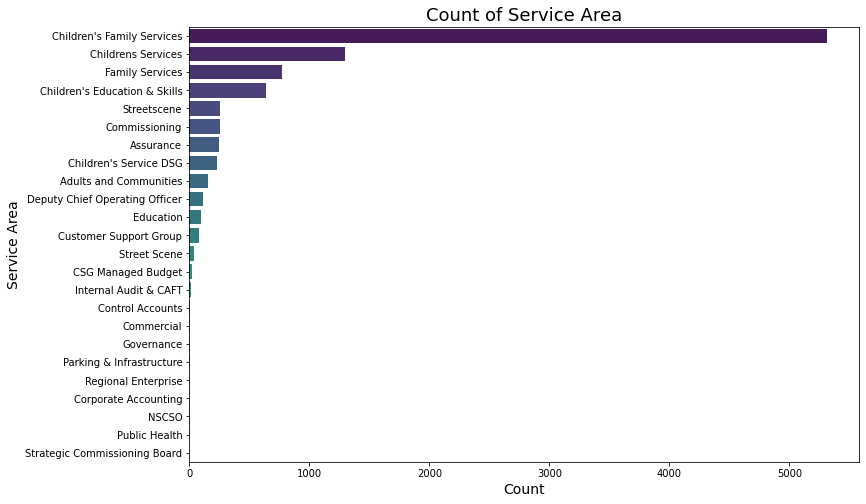

In [18]:
## Nunbers of service areas

print('Number of Service Areas:', data['Service Area'].nunique())

# Plot All service areas
plt.figure(figsize=(12, 8))
sns.countplot(y='Service Area', data=data, palette='viridis', order=data['Service Area'].value_counts().index)
plt.title('Count of Service Area', fontsize=18)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Service Area', fontsize=14)
plt.show()



Number of Account Description: 63
Top 10 Account Description: Equipment and Materials Purcha    2073
Food Costs                        1792
Travelling Expenses                922
Other Transfer Payments to Soc     563
Cleaning and domestic material     537
Other Services                     535
Miscellaneous Expenses             425
Books-CDs-Audio-Video              393
Building Repairs & Maintenance     379
Stationery                         225
Name: Account Description, dtype: int64


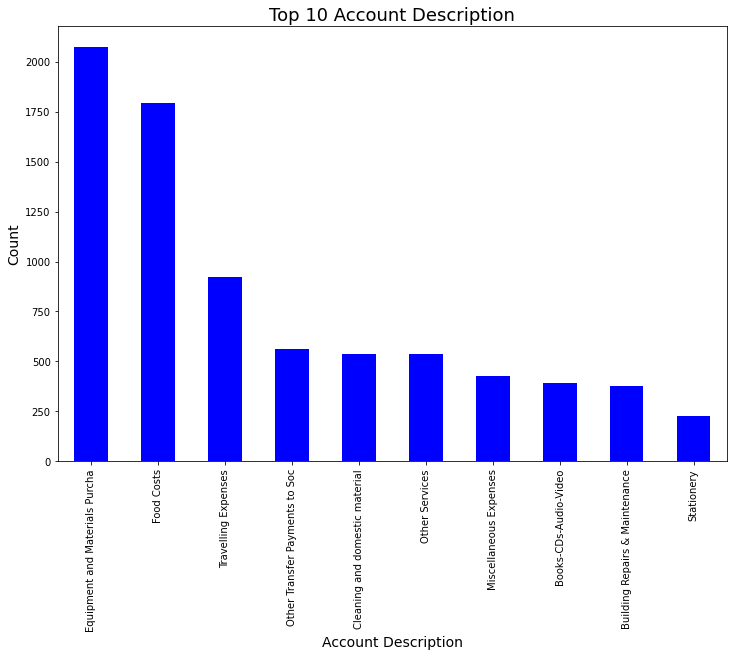

In [19]:
# Plot all accounts and count

print('Number of Account Description:', data['Account Description'].nunique())
top_10_account_description = data['Account Description'].value_counts().nlargest(10)
print('Top 10 Account Description:', top_10_account_description)


# Plot just top 10 accounts

top_10_account_description.plot(kind='bar', figsize=(12, 8), color='blue')
plt.title('Top 10 Account Description', fontsize=18)
plt.xlabel('Account Description', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [20]:
service_area_unique = data['Service Area'].unique()
account_description_unique = data['Account Description'].unique()
creditors_unique = data['Creditor'].unique()

# Print counts for each category
print(f'Number of Service Areas: {len(service_area_unique)}')
print(f'Number of Account Descriptions: {len(account_description_unique)}')
print(f'Number of Creditors: {len(creditors_unique)}')

Number of Service Areas: 24
Number of Account Descriptions: 63
Number of Creditors: 1592


## Summary Data

Based on the provided data, the dataset contains 6 columns and 12386 rows. Key observations include:

- Although there are some missing values, their low percentage allows for their removal without significantly affecting the analysis.
- Duplicates values were removed
- Some columns have incorrect data types that need to be corrected.

The analyzed data encompasses approximately 9612 records spanning from 2014 to 2017 after removing duplicates, representing credit card transactions in the London borough of Barnet. Each record includes key fields such as service area, account, creditor, journal date, journal reference, and total (i.e., transaction amount). The data was consolidated from three separate files for the purpose of this analysis, and as part of the data cleaning process,

In summary, the dataset features 24 service areas, 63 accounts, and 1592 creditors. Transactions range from a credit of - 4,707 to a max of 11487.

# Analysis Request:
 
1.       Auditor would like to get a summary view of the transactions for each Service Area. The summary view would include at least one visual representation of the transactions in such a way that she could compare them by quarter. Quarters are defined based on the calendar year (Q1 is January to March, Q2 April to June, etc.). She would also like a summary table with some relevant statistics (she says something along the lines of “transaction counts and averages”, but she welcomes ideas).
2.       Auditor would like to get a view if there are any significant changes in spending behavior by Service Area and by Account. Changes in behavior could be spikes, but could also be permanent increases in the transaction amounts. Please identify instances of both or show that they do not exist in the data.
3.       In terms of spending behavior (defined by the number and the typical size of transactions), are there Service Areas that behave similarly and can be grouped together? Please explain the value of your grouping for the Auditor’s work.
4.       The auditor has heard that you may know anomaly detection techniques. She would like to ask you for a sample of a few hundred transactions that are anomalous, different or worthwhile inquiring about.  The sample should include at least five transactions for each Service Area. Please provide this sample, and explain why these transactions are special or different.


## 1. Summary view of the transactions for each Service Area
In this section the

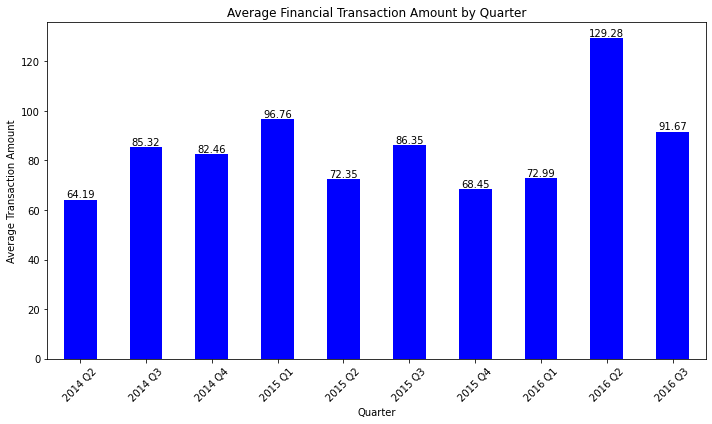

In [21]:
average_by_quarter = data.groupby('Quarter')['Total'].mean()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
average_by_quarter.plot(kind='bar', color='blue')

# Annotating the bar graph with the average values
for i, value in enumerate(average_by_quarter):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.title('Average Financial Transaction Amount by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Transaction Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

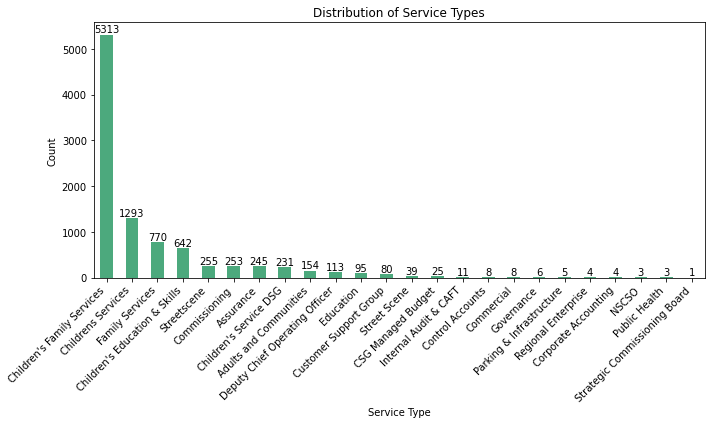

In [22]:
# Count occurrences of each service area
service_counts = data['Service Area'].value_counts()

plt.figure(figsize=(10, 6))
service_counts.plot(kind='bar', color='#4CA97D')
plt.title('Distribution of Service Types')
plt.xlabel('Service Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  

for i, count in enumerate(service_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [23]:
# Group by 'Service Area' and 'Quarter'
summary = data.groupby(['Service Area', 'Quarter']).agg(
    Transaction_Count=('Total', 'count'),
    Average_Amount=('Total', 'mean'),
    Total_Amount=('Total', 'sum')
).reset_index()


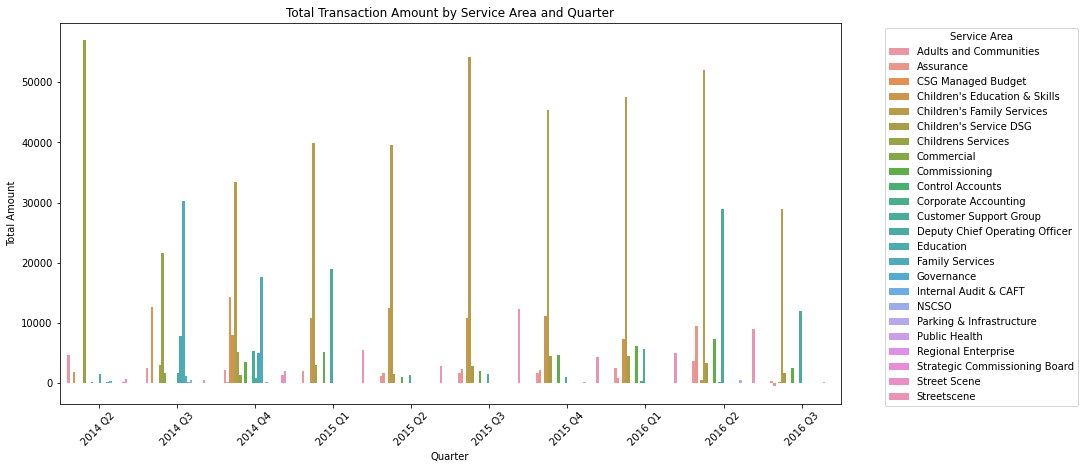

In [54]:
plt.figure(figsize=(14, 7))
sns.barplot(x='Quarter', y='Total_Amount', hue='Service Area', data=summary)
plt.title('Total Transaction Amount by Service Area and Quarter')
plt.xticks(rotation=45)
plt.ylabel('Total Amount')
plt.legend(title='Service Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [25]:
service_areas = np.unique(data['Service Area'])
num_service_areas = len(service_areas)

In [26]:
quarters = np.unique(data['Quarter'])
num_quarters = len(quarters)

In [52]:
### create grouped summary table for all aggregates


# Set display options for pandas
pd.options.display.float_format = '{:,.0f}'.format
pd.set_option('display.max_rows', num_service_areas * num_quarters)

# Group data by 'Service Area' and 'Quarter'
grouped_data = data.groupby(['Service Area', 'Quarter'])

# Create a summary table with count, sum, and mean of transactions
transaction_summary = grouped_data['Total'].agg(['count', 'sum', 'mean'])

# Rename the columns for better readability
transaction_summary.columns = ['Transaction Count', 'Transaction Sum', 'Average Transaction']


In [53]:
# Display the summary table
display(transaction_summary)

Transaction Count  Transaction Sum  \
Service Area                   Quarter                                       
Adults and Communities         2014 Q2                 16            4,608   
                               2014 Q3                  8            2,570   
                               2014 Q4                 18            2,149   
                               2015 Q1                 11            2,018   
                               2015 Q2                  8            1,187   
                               2015 Q3                 15            1,636   
                               2015 Q4                 18            1,648   
                               2016 Q1                 23            2,469   
                               2016 Q2                 25            3,659   
                               2016 Q3                 12              414   
Assurance                      2014 Q4                  3              105   
                               2015 Q1                  4               67   
                               2015 Q2                 51            1,685   
                               2015 Q3                 39            2,262   
                               2015 Q4                 30            2,110   
                               2016 Q1                 29              849   
                               2016 Q2                 60            9,510   
                               2016 Q3                 29             -533   
CSG Managed Budget             2014 Q2                 13            1,809   
                               2014 Q3                  8           12,616   
                               2014 Q4                  4           14,270   
Children's Education & Skills  2014 Q4                 72            8,036   
                               2015 Q1                165           10,836   
                               2015 Q2                160           12,525   
                               2015 Q3                 96           10,778   
                               2015 Q4                 86           11,116   
                               2016 Q1                 54            7,368   
                               2016 Q2                  5              476   
                               2016 Q3                  4              118   
Children's Family Services     2014 Q4                597           33,509   
                               2015 Q1                607           39,859   
                               2015 Q2                585           39,641   
                               2015 Q3                747           54,285   
                               2015 Q4                814           45,323   
                               2016 Q1                859           47,483   
                               2016 Q2                682           52,034   
                               2016 Q3                422           28,907   
Children's Service DSG         2014 Q3                 31            3,048   
                               2014 Q4                 32            5,214   
                               2015 Q1                 15            3,031   
                               2015 Q2                 12            1,543   
                               2015 Q3                 20            2,776   
                               2015 Q4                 59            4,531   
                               2016 Q1                 31            4,457   
                               2016 Q2                 24            3,343   
                               2016 Q3                  7            1,716   
Childrens Services             2014 Q2                943           56,973   
                               2014 Q3                330           21,560   
                               2014 Q4                 20            1,264   
Commercial                     2014 Q3                  8     

In [29]:
# Function to create a pivot table for one aggregate overall (across all service areas)
def create_qtr_agg_table_overall(data, num_quarters, quarters, agg_func):

    aggs = np.zeros(num_quarters)
    for qtr in range(num_quarters):
        aggs[qtr] = agg_func(data[data['Quarter'] == quarters[qtr]]['Total'])
    aggs[np.isnan(aggs)] = 0.0  # Replace NaN values with 0.0
    aggs_df = pd.DataFrame(aggs.reshape(-1, 1), columns=['Aggregate'])
    aggs_df.index = quarters

    return aggs_df

# Function to create a pivot table for one aggregate per service area
def create_qtr_agg_table(data, num_service_areas, num_quarters, service_areas, quarters, agg_func):

    aggs = np.zeros((num_service_areas, num_quarters))
    for area in range(num_service_areas):
        for qtr in range(num_quarters):
            aggs[area, qtr] = agg_func(data[(data['Service Area'] == service_areas[area]) & 
                                            (data['Quarter'] == quarters[qtr])]['Total'])
    aggs[np.isnan(aggs)] = 0.0  # Replace NaN values with 0.0
    aggs_df = pd.DataFrame(aggs, index=service_areas, columns=quarters)

    return aggs_df


# Create aggregate tables for all service areas combined
area_counts_qtr_overall = create_qtr_agg_table_overall(data, num_quarters, quarters, np.count_nonzero)
area_sums_qtr_overall = create_qtr_agg_table_overall(data, num_quarters, quarters, np.sum)
area_means_qtr_overall = create_qtr_agg_table_overall(data, num_quarters, quarters, np.mean)

# Create aggregate tables for each service area
area_counts_qtr = create_qtr_agg_table(data, num_service_areas, num_quarters, service_areas, quarters, np.count_nonzero)
area_sums_qtr = create_qtr_agg_table(data, num_service_areas, num_quarters, service_areas, quarters, np.sum)
area_means_qtr = create_qtr_agg_table(data, num_service_areas, num_quarters, service_areas, quarters, np.mean)

# Calculate overall counts and means for each service area
area_counts = area_counts_qtr.sum(axis=1).values.reshape(-1, 1).astype(int)
area_means = area_sums_qtr.sum(axis=1).values.reshape(-1, 1).astype(float) / area_counts



In [30]:
def do_one_subplot(ax, heights, color, agg_name, title):
    
    # set bar indexes and width
    ind = np.arange(num_quarters)  
    width = 0.35 

    # create subplot
    ax.bar(ind, heights, width, color = color)
    ax.set_xticks(ind + (width/2))
    ax.set_xticklabels(quarters)
    ax.set_xlim(-0.5, num_quarters)

    # label subplot
    ax.set_xlabel("Quarter")
    ax.set_ylabel(agg_name)
    ax.set_title(title)

In [31]:
def plot_transactions(table, agg_name, color = 'darkblue'):

    # allocate subplots
    fig, ax_ar = plt.subplots(num_service_areas, 1, figsize = (8, 48))

    # create all subplots
    for index in range(num_service_areas):
        do_one_subplot(ax_ar[index], table.iloc[index, :], color, agg_name, service_areas[index])

    # show plot
    plt.tight_layout()
    plt.show()

### Transcation counts by quarter

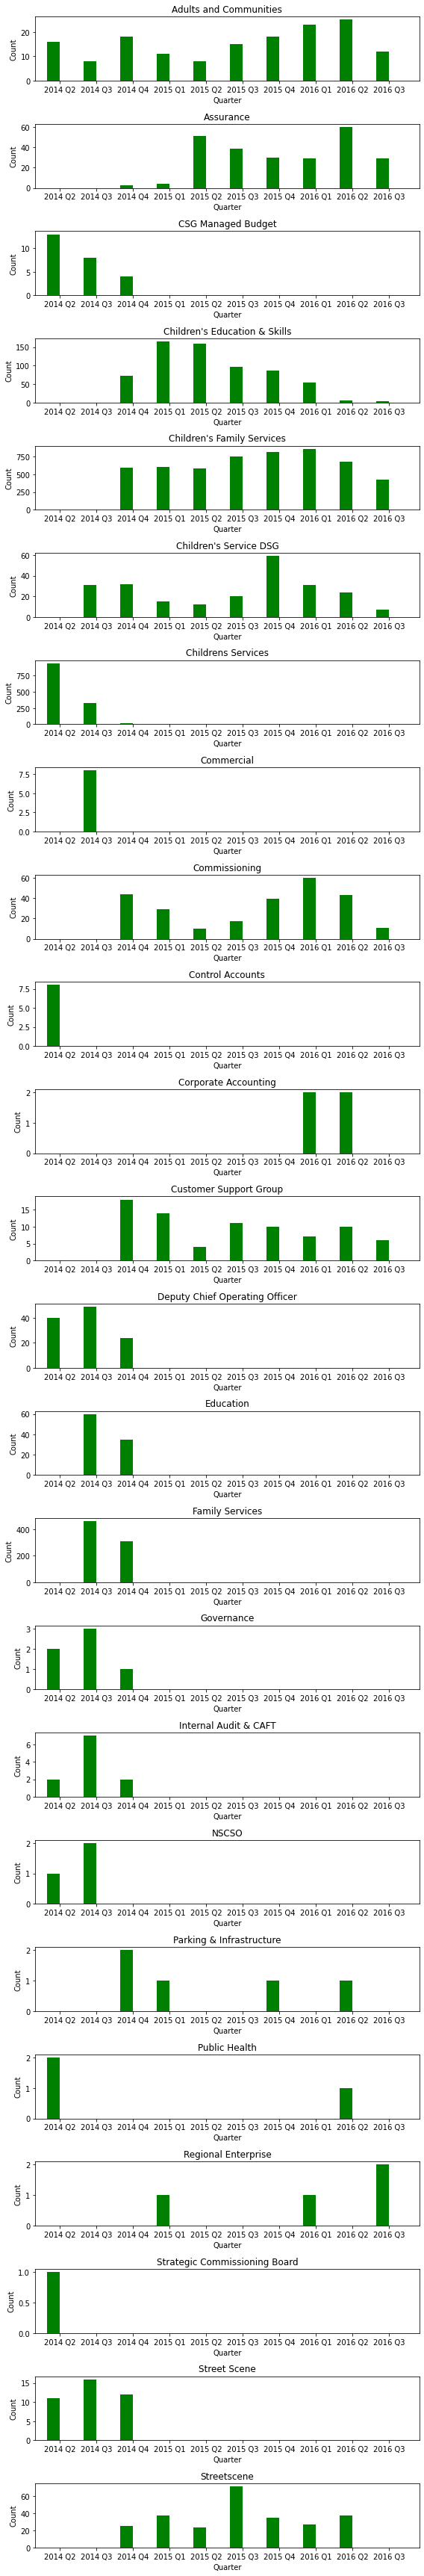

In [32]:
plot_transactions(area_counts_qtr, "Count", 'green')


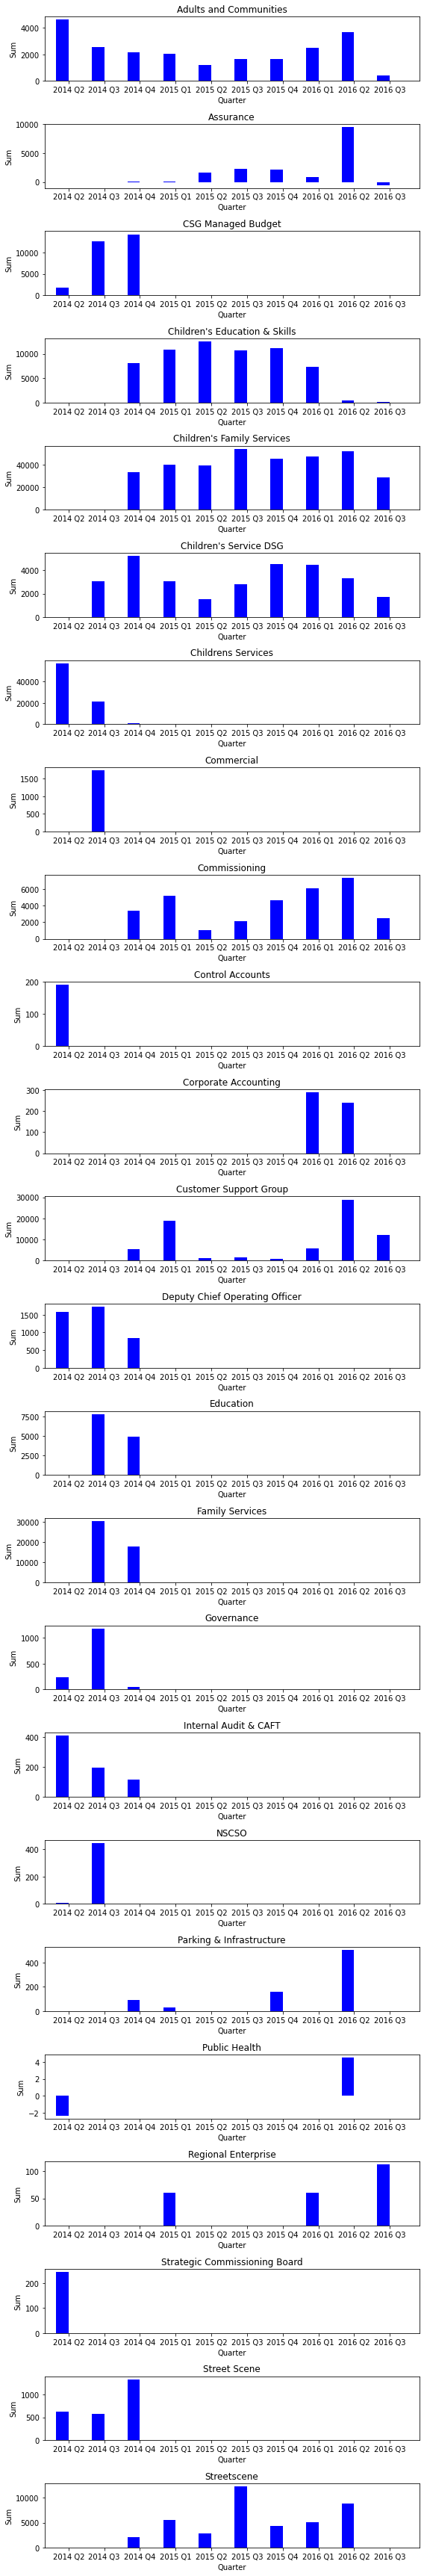

In [33]:
plot_transactions(area_sums_qtr, "Sum", 'blue')

### Transaction Averages by Quarter

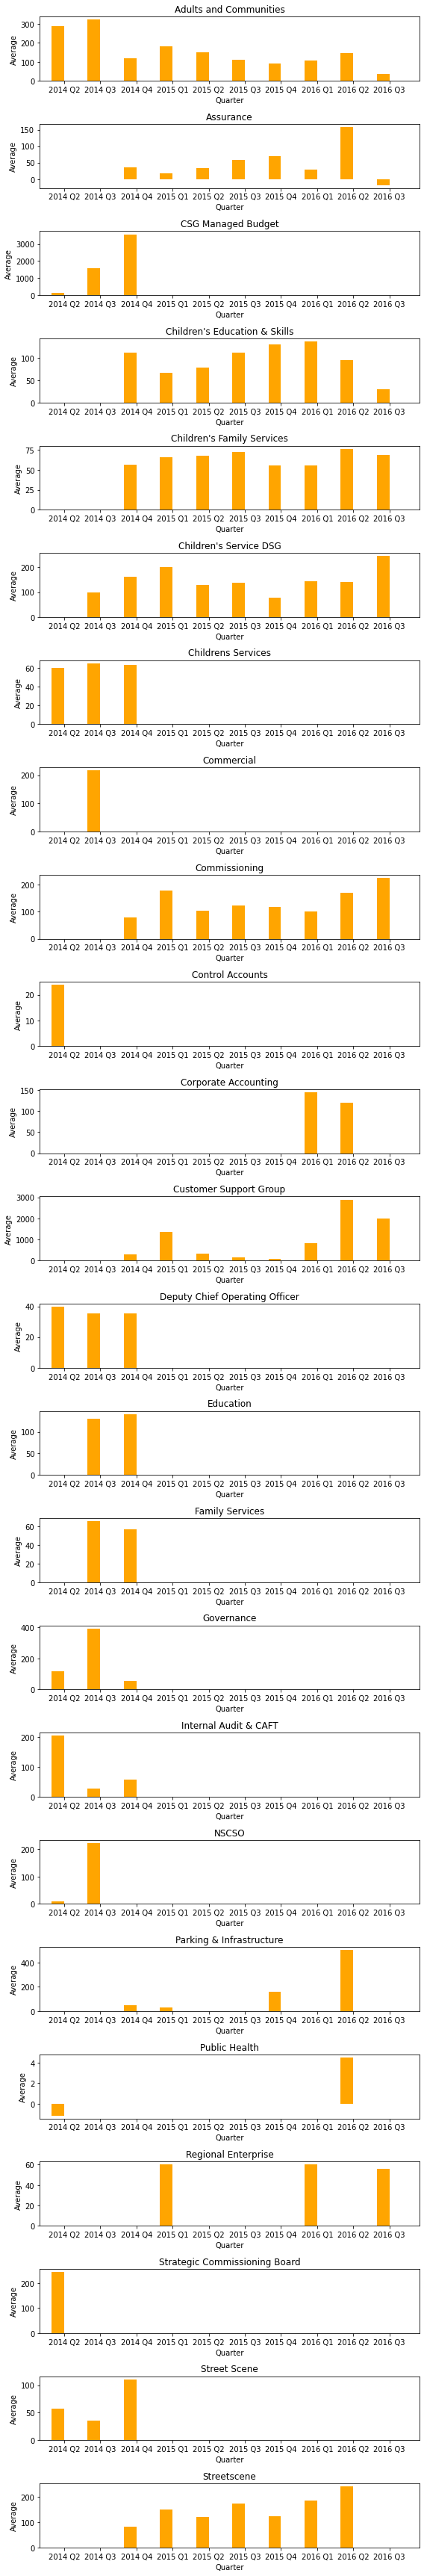

In [34]:
plot_transactions(area_means_qtr, "Average", 'orange')

I provide four summary tables to support the graphs with quantitative data. The first table is a hierarchical breakdown of quarterly spending by service area, listing only the active quarters for each service area. This table includes all three aggregates: transaction counts, sums, and averages. The next three tables individually cover these aggregates, broken down by service area and quarter. The hierarchical table is useful for focusing on specific service areas, while the grid tables help in analyzing trends over time.

## Transaction Summary (by Service Area)

In [35]:
display(summary)

,Service Area,Quarter,Transaction_Count,Average_Amount,Total_Amount
0,Adults and Communities,2014 Q2,16,288,"4,608"
1,Adults and Communities,2014 Q3,8,321,"2,570"
2,Adults and Communities,2014 Q4,18,119,"2,149"
3,Adults and Communities,2015 Q1,11,183,"2,018"
4,Adults and Communities,2015 Q2,8,148,"1,187"
5,Adults and Communities,2015 Q3,15,109,"1,636"
6,Adults and Communities,2015 Q4,18,92,"1,648"
7,Adults and Communities,2016 Q1,23,107,"2,469"
8,Adults and Communities,2016 Q2,25,146,"3,659"
9,Adults and Communities,2016 Q3,12,35,414


In [36]:
#Transaction Counts (by Service Area and Quarter)
display(area_counts_qtr)

,2014 Q2,2014 Q3,2014 Q4,2015 Q1,2015 Q2,2015 Q3,2015 Q4,2016 Q1,2016 Q2,2016 Q3
Adults and Communities,16,8,18,11,8,15,18,23,25,12
Assurance,0,0,3,4,51,39,30,29,60,29
CSG Managed Budget,13,8,4,0,0,0,0,0,0,0
Children's Education & Skills,0,0,72,165,160,96,86,54,5,4
Children's Family Services,0,0,597,607,585,747,813,859,682,422
Children's Service DSG,0,31,32,15,12,20,59,31,24,7
Childrens Services,943,330,20,0,0,0,0,0,0,0
Commercial,0,8,0,0,0,0,0,0,0,0
Commissioning,0,0,44,29,10,17,39,60,43,11
Control Accounts,8,0,0,0,0,0,0,0,0,0


In [37]:
#Transaction Sums (by Service Area and Quarter)
display(area_sums_qtr)

,2014 Q2,2014 Q3,2014 Q4,2015 Q1,2015 Q2,2015 Q3,2015 Q4,2016 Q1,2016 Q2,2016 Q3
Adults and Communities,"4,608","2,570","2,149","2,018","1,187","1,636","1,648","2,469","3,659",414
Assurance,0,0,105,67,"1,685","2,262","2,110",849,"9,510",-533
CSG Managed Budget,"1,809","12,616","14,270",0,0,0,0,0,0,0
Children's Education & Skills,0,0,"8,036","10,836","12,525","10,778","11,116","7,368",476,118
Children's Family Services,0,0,"33,509","39,859","39,641","54,285","45,323","47,483","52,034","28,907"
Children's Service DSG,0,"3,048","5,214","3,031","1,543","2,776","4,531","4,457","3,343","1,716"
Childrens Services,"56,973","21,560","1,264",0,0,0,0,0,0,0
Commercial,0,"1,735",0,0,0,0,0,0,0,0
Commissioning,0,0,"3,425","5,189","1,036","2,092","4,619","6,107","7,370","2,486"
Control Accounts,191,0,0,0,0,0,0,0,0,0


In [38]:
#Transaction Averages (by Service Area and Quarter)
display(area_means_qtr)

,2014 Q2,2014 Q3,2014 Q4,2015 Q1,2015 Q2,2015 Q3,2015 Q4,2016 Q1,2016 Q2,2016 Q3
Adults and Communities,288,321,119,183,148,109,92,107,146,35
Assurance,0,0,35,17,33,58,70,29,159,-18
CSG Managed Budget,139,"1,577","3,568",0,0,0,0,0,0,0
Children's Education & Skills,0,0,112,66,78,112,129,136,95,30
Children's Family Services,0,0,56,66,68,73,56,55,76,68
Children's Service DSG,0,98,163,202,129,139,77,144,139,245
Childrens Services,60,65,63,0,0,0,0,0,0,0
Commercial,0,217,0,0,0,0,0,0,0,0
Commissioning,0,0,78,179,104,123,118,102,171,226
Control Accounts,24,0,0,0,0,0,0,0,0,0


# Significant spikes in spending behaviours:

2: Auditor would like to get a view if there are any significant changes in spending behavior by Service Area and by Account. Changes in behavior could be spikes, but could also be permanent increases in the transaction amounts. Please identify instances of both or show that they do not exist in the data.
To retrieve a manageable number of transactions, we set a threshold at the top 2% of transactions within each service area or account.

To retrieve more transactions for consideration as possible anomalies, potentially increase the threshold above 2%.

Results below show 17 quarterly spikes in transaction amounts among the service areas. The listed spikes correspond to unusually tall bars in the summary graphs below, which helps to confirm the results. Results also show 40 spikes among the accounts. Since there are approximately three times as many accounts as service areas, this approximate ratio of 3 to 1 in spikes is reasonable.

Using Z-scores to identify spikes in transaction amounts. A Z-score greater than > 2 threshold  can indicate a spike.

In [39]:
accounts = np.unique(data['Account Description'])
quarters = np.unique(data['Quarter'])
num_accounts = np.unique(data['Account Description']).shape[0]
num_quarters = np.unique(data['Quarter']).shape[0]
num_services_areas = np.unique(data['Service Area']).shape[0]
services_ares = np.unique(data['Service Area'])

print('Number of Accounts:', num_accounts)
print('Number of Quarters:', num_quarters)

Number of Accounts: 63
Number of Quarters: 10


In [40]:

# Calculate account sums by quarter
account_sums_qtr = np.zeros((num_accounts, num_quarters))
for account in range(num_accounts):
    for qtr in range(num_quarters):
        account_sums_qtr[account, qtr] = np.sum(data[(data['Account Description'] == accounts[account]) & 
                                                     (data['Quarter'] == quarters[qtr])]['Total'])

# Create a DataFrame for account sums by quarter
account_sums_qtr_df = pd.DataFrame(account_sums_qtr, columns=quarters, index=accounts)


# Calculate quarterly means and variances
area_sum_qtr_means = area_sums_qtr.mean(axis=1).values.reshape(-1, 1)
area_sum_qtr_vars = area_sums_qtr.var(axis=1).values.reshape(-1, 1)

account_sum_qtr_means = account_sums_qtr.mean(axis=1).reshape(-1, 1)
account_sum_qtr_vars = account_sums_qtr.var(axis=1).reshape(-1, 1)

# Calculate quarterly spikes in service areas
pd.options.display.float_format = '{:,.2f}'.format
spikes = []

for index in range(num_service_areas):
    for qtr in range(num_quarters):
        z_score = float((area_sums_qtr.iloc[index, qtr] - area_sum_qtr_means[index]) / np.sqrt(area_sum_qtr_vars[index]))
        if z_score > 2:
            spikes.append((service_areas[index], quarters[qtr], area_sums_qtr.iloc[index, qtr], z_score))

spikes_df = pd.DataFrame(spikes, columns=['Service Area', 'Quarter', 'Transaction Sum', 'SDs from Average'])

# Display the spikes DataFrame sorted by standard deviations from average
display(spikes_df.sort_values(by='SDs from Average', ascending=False).reset_index(drop=True))


,Service Area,Quarter,Transaction Sum,SDs from Average
0,Strategic Commissioning Board,2014 Q2,244.00,2.85
1,Commercial,2014 Q3,"1,735.05",2.85
2,Control Accounts,2014 Q2,190.71,2.85
3,NSCSO,2014 Q3,445.50,2.85
4,Governance,2014 Q3,"1,176.96",2.79
5,Assurance,2016 Q2,"9,510.24",2.68
6,Parking & Infrastructure,2016 Q2,500.00,2.67
7,Childrens Services,2014 Q2,"56,972.56",2.65
8,Public Health,2016 Q2,4.55,2.56
9,Internal Audit & CAFT,2014 Q2,407.20,2.48


In [41]:
### calculate quarterly spikes in accounts

pd.options.display.float_format = '{:,.2f}'.format
spikes = []

for index in range(num_accounts):
    for qtr in range(num_quarters):
        z_score = float((account_sums_qtr[index, qtr] - account_sum_qtr_means[index]) \
                    / np.power(account_sum_qtr_vars[index], 0.5))
        if z_score > 2.0:
            spikes.append((accounts[index], quarters[qtr], account_sums_qtr[index, qtr], z_score))

spikes_df = pd.DataFrame(spikes, columns = ['Account', 'Quarter', 'Transaction Sum', 'SDs from Average'])
display(spikes_df.sort_values(by = 'SDs from Average', ascending = False).reset_index(drop = True))

,Account,Quarter,Transaction Sum,SDs from Average
0,Advertising for staff,2016 Q2,450.00,3.00
1,Catering Recharge,2016 Q1,100.00,3.00
2,Clothing - Uniforms,2014 Q3,107.50,3.00
3,Operating Leases - Transport,2016 Q1,65.83,3.00
4,Non Education Staff GPay,2016 Q2,115.80,3.00
5,Grant Payments,2015 Q3,660.00,3.00
6,Gas,2016 Q2,"1,695.22",3.00
7,Furniture-Purchase-Repair,2016 Q3,115.95,3.00
8,Employer's National Insurance,2015 Q4,6.67,3.00
9,NNDR Collected,2016 Q2,4.10,3.00


Account that are showing SDs from Average greater than 2 are identified having a spike/ outlier in the behaviour.

In [42]:
# find permanent changes in spending by service areas
changes = []
for area in range(num_service_areas):
    for qtr in range(1, num_quarters - 1):
        before_mean = area_sums_qtr.iloc[area, :(qtr + 1)].mean()
        after_mean = area_sums_qtr.iloc[area, (qtr + 1):].mean()
        var = area_sums_qtr.iloc[area, 1:].var()
        means_diff = after_mean - before_mean
        z_score = means_diff / np.power(var, 0.5)
        
        # flag positive changes where long_term averages increase by more than 1 SD
        if (z_score > 1) and (area_sums_qtr.iloc[area, qtr] < area_sums_qtr.iloc[area, (qtr + 1)]):
            changes.append((service_areas[area], quarters[qtr + 1], before_mean, after_mean, z_score))
            
changes_df = pd.DataFrame(changes, columns = ['Service Area', 'After Quarter', 'Old Average', \
                                             'New Average', 'SDs Change'])
changes_df = changes_df[changes_df['Old Average'] > 0]
display(changes_df.reset_index(drop = True))

,Service Area,After Quarter,Old Average,New Average,SDs Change
0,Assurance,2016 Q2,884.94,"4,488.68",1.18
1,Children's Family Services,2015 Q1,"11,169.57","43,932.98",1.99
2,Children's Family Services,2015 Q3,"22,601.58","45,606.34",1.40
3,Children's Service DSG,2014 Q4,"1,523.87","3,326.34",1.44
4,Commissioning,2015 Q1,"1,141.80","4,128.40",1.23
5,Commissioning,2015 Q3,"1,930.23","4,534.61",1.07
6,Commissioning,2015 Q4,"1,957.16","5,145.30",1.31
7,Commissioning,2016 Q1,"2,337.38","5,320.86",1.23
8,Customer Support Group,2016 Q1,"4,016.81","15,541.33",1.16
9,Customer Support Group,2016 Q2,"4,222.61","20,480.39",1.64


In [43]:
# find permanent changes in spending by accounts
changes = []
for account in range(num_accounts):
    for qtr in range(1, num_quarters - 1):
        before_mean = account_sums_qtr[account, :(qtr + 1)].mean()
        after_mean = account_sums_qtr[account, (qtr + 1):].mean()
        var = account_sums_qtr[account, 1:].var()
        means_diff = after_mean - before_mean
        z_score = means_diff / np.power(var, 0.5)
        
        # flag positive changes where long_term averages increase by more than 1 SD
        if (z_score > 1) and (area_sums_qtr.iloc[area, qtr] < area_sums_qtr.iloc[area, (qtr + 1)]):
            changes.append((accounts[account], quarters[qtr + 1], before_mean, after_mean, z_score))
            
changes_df = pd.DataFrame(changes, columns = ['Account', 'Starting Quarter', 'Old Average', \
                                             'New Average', 'SDs Change'])
changes_df = changes_df[changes_df['New Average'] > 0]
display(changes_df.reset_index(drop = True))

,Account,Starting Quarter,Old Average,New Average,SDs Change
0,Advertising for staff,2016 Q1,0.00,150.00,1.06
1,Advertising for staff,2016 Q2,0.00,225.00,1.59
2,Catering Recharge,2016 Q1,0.00,33.33,1.06
3,Conference Expenses,2015 Q3,259.36,866.86,1.28
4,Conference Expenses,2016 Q1,415.40,907.77,1.03
5,Consultants Fees,2016 Q1,0.00,320.00,1.14
6,Consultants Fees,2016 Q2,7.50,450.00,1.57
7,E19 - Learning Resources,2015 Q3,24.59,292.87,1.06
8,E25 - Catering Supplies,2015 Q3,24.83,678.47,1.17
9,Education CFR Administrative S,2015 Q3,44.21,845.21,1.21


# Grouping Service Areas

3. In terms of spending behavior (defined by the number and the typical size of transactions), are there Service Areas that behave similarly and can be grouped together? Please explain the value of your grouping for the Auditor’s work.


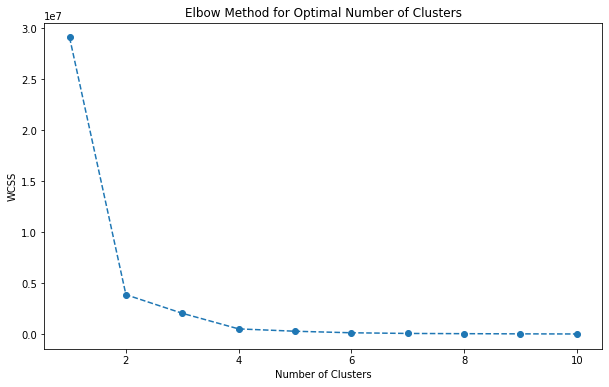

In [44]:
from sklearn.cluster import KMeans

area_counts = np.array(area_counts_qtr.sum(axis = 1)).reshape(-1, 1).astype(int)
area_means = np.array(area_sums_qtr.sum(axis = 1)).reshape(-1, 1).astype(float) / area_counts

## prepare predictors
predictors = np.concatenate((area_counts, area_means), axis = 1)

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(predictors)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()




In [45]:
# create and fit K-means model 
n_clusters = 4 # optimal clusters

model = KMeans(n_clusters = n_clusters)
predict = model.fit_predict(predictors)
cluster_centers = model.cluster_centers_

new_col = np.zeros(data.shape[0]).reshape(-1, 1)
for index in range(num_services_areas):
    area_name = services_ares[index]
    area_indexes = np.where(data['Service Area'] == area_name)
    new_col[area_indexes] = predict[index]
    
new_col_df = pd.DataFrame(new_col, columns = ['Cluster'])
data_kmeans = pd.concat((data, new_col_df), axis = 1)

In [46]:
# group clusters with service area names
results = np.concatenate((predict.reshape(-1, 1), services_ares.reshape(-1, 1)), axis = 1)
results_df = pd.DataFrame(results, columns = ['Cluster', 'Service Area'])
clusters = results_df.groupby('Cluster')

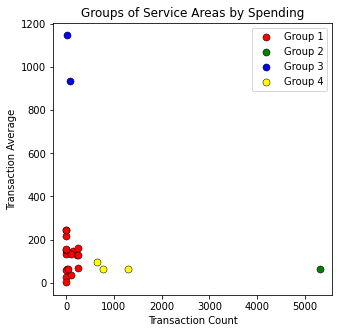

In [47]:
### plot clusters
colors = ['r', 'g', 'b', 'yellow']

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(1, 1, 1)

for cluster in range(n_clusters):
    cluster_counts = area_counts[predict == cluster]
    cluster_means = area_means[predict == cluster]
    ax.scatter(cluster_counts, cluster_means, color = colors[cluster], s = 50,
               edgecolor = 'black', linewidth = 0.5, label = 'Group ' + str(cluster + 1))

ax.set_xlabel("Transaction Count")
ax.set_ylabel("Transaction Average")
ax.set_title("Groups of Service Areas by Spending")
ax.legend(loc = 'best')

plt.show()

In [48]:
# List clusters
for key, item in enumerate(clusters):
    print(f"\tGROUP {key + 1}   (Center: Count = {int(cluster_centers[key, 0])}, Average = £{int(round(cluster_centers[key, 1]))})")
    print()
    
    cluster_df = pd.DataFrame(clusters.get_group(key).iloc[:, 1])
    for area in range(cluster_df.shape[0]):
        print(f"\t\t{cluster_df.iloc[area, 0]}")
    
    print()
    print()


	GROUP 1   (Center: Count = 79, Average = £120)

		Adults and Communities
		Assurance
		Children's Service DSG
		Commercial
		Commissioning
		Control Accounts
		Corporate Accounting
		Deputy Chief Operating Officer
		Education
		Governance
		Internal Audit & CAFT
		NSCSO
		Parking & Infrastructure
		Public Health
		Regional Enterprise
		Strategic Commissioning Board
		Street Scene
		Streetscene


	GROUP 2   (Center: Count = 5312, Average = £64)

		Children's Family Services


	GROUP 3   (Center: Count = 52, Average = £1041)

		CSG Managed Budget
		Customer Support Group


	GROUP 4   (Center: Count = 901, Average = £73)

		Children's Education & Skills
		Childrens Services
		Family Services




After looking at the spending patterns above,  try to find out certain service areas were similar in behavior. For this, I considered the number and average of borough transactions. A well-known algorithm for grouping objects/ segmentation is called "k-means clustering". 

- Using Elbow method I found four reasonable groups of service areas. The graph above shows these groups. The goal was to find groups that shared one data attribute (e.g., similar transaction averages), but varied a bit on the other attribute. The groups are as follows:

- Group 1 has a few, small transactions per service area. Each area shows approximately 79 transactions that average 122 in amount.
- Group 2 has many, small transactions. The one area in this group shows 5317 transactions that average £64 in amount is Children's Family Services.
- Group 3 has a moderate number of small transactions per service area. Each area shows approximately 901 transactions that average £73 in amount.
- Group 4 has a small number of large transactions. Each area shows approximately 52 transactions that average £1041 in amount.


Understanding the spending patterns of different clusters can help the auditor focus on areas with unusual spending behaviors or those that require further investigation.

# Anamoly Detection

In [49]:
# Initializing an empty DataFrame to store anomalous transactions
anomalous_transactions = pd.DataFrame(columns=data.columns)

# Initializing and fitting Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)

# Dictionary to map comments with their corresponding criteria
comments = {
    'Unusually high transaction amount.': 'Total',
    'Transaction with unusual combination of features.': ['Account Description', 'Creditor', 'Journal Date', 'Journal Reference', 'Total'],
    'Journal date is outside expected range.': 'Journal Date',
    'Unexpected journal reference associated with the transaction.': 'Journal Reference',
    'Outlier in terms of total amount compared to other transactions in the same area.': 'Total'
}

# Iterating over the comments dictionary
for comment, criteria in comments.items():
    # Fit Isolation Forest model on the data based on the specific criteria
    if isinstance(criteria, list):
        numeric_criteria = [col for col in criteria if data[col].dtype in ['int64', 'float64']]
        model.fit(data[numeric_criteria])
    else:
        if data[criteria].dtype in ['int64', 'float64']:
            model.fit(data[[criteria]])
        else:
            continue
    
    # Predicting outliers/anomalies
    anomaly_pred = model.predict(data[numeric_criteria] if isinstance(criteria, list) else data[[criteria]])
    
    # Filtering out anomalies
    anomalies = data[anomaly_pred == -1]
    
    # Sample at most 5 transactions for the current comment
    sampled_anomalies = anomalies.groupby('Service Area').head(5)
    
    # Adding comments to the sampled anomalies
    sampled_anomalies['Comment'] = comment
    
    # Append sampled anomalies to the anomalous_transactions DataFrame
    anomalous_transactions = anomalous_transactions.append(sampled_anomalies)


In [50]:
# Group anomalies by 'Service Area' and display at least 5 transactions per area
grouped_anomalies = anomalous_transactions.groupby('Service Area')

for name, group in grouped_anomalies:
    print(f"Service Area: {name}")
    display(group.head(5))
    print('-' * 80)  # separator for readability

Service Area: Adults and Communities


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
214,Adults and Communities,Subsistence,PREMIER INN,2014-04-30,289.00,815.50,2014 Q2,Unusually high transaction amount.
215,Adults and Communities,Subsistence,PREMIER INN,2014-04-30,290.00,815.50,2014 Q2,Unusually high transaction amount.
307,Adults and Communities,Other Services,VOUCHER EXPRESS B2B,2014-04-07,190.00,400.00,2014 Q2,Unusually high transaction amount.
524,Adults and Communities,Books-CDs-Audio-Video,HAMMICKS LEGAL FLEE,2014-05-02,817.00,411.00,2014 Q2,Unusually high transaction amount.
887,Adults and Communities,Training,HEALTHCARE CONFEREN,2014-06-26,"1,075.00",474.00,2014 Q2,Unusually high transaction amount.


--------------------------------------------------------------------------------
Service Area: Assurance


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
6068,Assurance,Other Services,GOLDEN BOY COACHES,2015-05-19,"3,145.00",448.00,2015 Q2,Unusually high transaction amount.
7412,Assurance,Stationery,SNA MANUFACTURING LTD,2015-09-29,"5,477.00",660.50,2015 Q3,Unusually high transaction amount.
7752,Assurance,Pool Transport Charges,THE CONFERENCE NET,2015-07-15,"4,662.00",396.00,2015 Q3,Unusually high transaction amount.
8432,Assurance,Equipment and Materials Purcha,PP HIREWITNESS,2016-07-15,"8,752.00",370.00,2016 Q3,Unusually high transaction amount.
8618,Assurance,Fixtures and fittings,MARQUEE CARPETS LIMITEWALTHAM CROSS,2016-08-19,"9,175.00","-1,315.20",2016 Q3,Unusually high transaction amount.


--------------------------------------------------------------------------------
Service Area: CSG Managed Budget


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
491,CSG Managed Budget,Legal and Court Fees,CAPITA BUS SVS-MOTO,2014-05-30,816.00,478.80,2014 Q2,Unusually high transaction amount.
606,CSG Managed Budget,Other Services,MR BOX LTD,2014-05-05,805.00,598.80,2014 Q2,Unusually high transaction amount.
843,CSG Managed Budget,Books-CDs-Audio-Video,Amazon Mktplce EU-U,2014-06-12,"1,194.00",-44.99,2014 Q2,Unusually high transaction amount.
891,CSG Managed Budget,Legal and Court Fees,HMCOURTS-SERVICE.G,2014-07-01,"1,247.00",795.00,2014 Q3,Unusually high transaction amount.
1543,CSG Managed Budget,Legal and Court Fees,HMCOURTS-SERVICE.G,2014-08-05,"1,916.00",663.00,2014 Q3,Unusually high transaction amount.


--------------------------------------------------------------------------------
Service Area: Children's Education & Skills


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
3058,Children's Education & Skills,Food Costs,COMPASS SERVICES UK,2014-11-28,"3,530.00",648.00,2014 Q4,Unusually high transaction amount.
3146,Children's Education & Skills,Equipment and Materials Purcha,KAYS DELICATESSEN,2014-11-27,"3,666.00",408.00,2014 Q4,Unusually high transaction amount.
3161,Children's Education & Skills,Food Costs,M D GRODZINSKI LTD,2014-11-26,"3,551.00",426.83,2014 Q4,Unusually high transaction amount.
3215,Children's Education & Skills,Private Contractors - Third Pa,REYNARDS UK LTD,2014-11-27,"3,667.00",400.00,2014 Q4,Unusually high transaction amount.
3218,Children's Education & Skills,Postage,ROYAL MAIL,2014-11-04,"3,659.00",387.50,2014 Q4,Unusually high transaction amount.


--------------------------------------------------------------------------------
Service Area: Children's Family Services


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
2891,Children's Family Services,Equipment and Materials Purcha,APPLE ONLINE STORE,2014-12-01,"3,645.00",749.00,2014 Q4,Unusually high transaction amount.
2892,Children's Family Services,Private Contractors - Third Pa,ARAGON 356-2248-497,2014-11-10,"3,978.00",-37.00,2014 Q4,Unusually high transaction amount.
2894,Children's Family Services,Other Transfer Payments to Soc,ARGOS DIRECT,2014-11-20,"3,905.00",-179.99,2014 Q4,Unusually high transaction amount.
2978,Children's Family Services,Books-CDs-Audio-Video,Amazon Mktplce EU-U,2014-11-12,"3,749.00",395.85,2014 Q4,Unusually high transaction amount.
3011,Children's Family Services,Equipment and Materials Purcha,Amazon Prime,2014-11-11,"3,915.00",-79.00,2014 Q4,Unusually high transaction amount.


--------------------------------------------------------------------------------
Service Area: Children's Service DSG


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
1615,Children's Service DSG,Books-CDs-Audio-Video,OXFORDUNIVERSITYPR,2014-08-14,"1,883.00",449.28,2014 Q3,Unusually high transaction amount.
1907,Children's Service DSG,Equipment and Materials Purcha,OXFORDUNIVERSITYPR,2014-09-22,"2,193.00",449.28,2014 Q3,Unusually high transaction amount.
2177,Children's Service DSG,Training,CAPITA BUS SVS-MOTO,2014-10-29,"3,445.00",420.00,2014 Q4,Unusually high transaction amount.
3301,Children's Service DSG,Books-CDs-Audio-Video,WP-THE BRITISH ASS,2014-11-18,"3,826.00",375.00,2014 Q4,Unusually high transaction amount.
3302,Children's Service DSG,Books-CDs-Audio-Video,WP-THE BRITISH ASS,2014-11-21,"3,827.00",375.00,2014 Q4,Unusually high transaction amount.


--------------------------------------------------------------------------------
Service Area: Childrens Services


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
96,Childrens Services,Private Contractors - Third Pa,CHICKEN SHED THEATR,2014-04-17,194.00,600.00,2014 Q2,Unusually high transaction amount.
108,Childrens Services,Training,DOD`S PARLIAMENTARY,2014-04-09,386.00,500.00,2014 Q2,Unusually high transaction amount.
217,Childrens Services,Consumable Catering Supplies,REYNARDS UK LTD,2014-04-14,11.00,387.79,2014 Q2,Unusually high transaction amount.
282,Childrens Services,Food Costs,TESCO STORES 644,2014-04-02,70.00,-230.30,2014 Q2,Unusually high transaction amount.
327,Childrens Services,Training,WWW.NASEN.ORG.UK,2014-04-10,215.00,581.90,2014 Q2,Unusually high transaction amount.


--------------------------------------------------------------------------------
Service Area: Commercial


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
1673,Commercial,Subscriptions,SOLACE LTD,2014-08-18,"1,895.00",594.00,2014 Q3,Unusually high transaction amount.
1738,Commercial,Private Contractors - Third Pa,WWW.FRIDGELAND.CO.U,2014-08-22,"1,897.00",717.35,2014 Q3,Unusually high transaction amount.
1841,Commercial,Private Contractors - Third Pa,EB LOCAL AUTHORITIE,2014-09-23,"2,223.00",-450.00,2014 Q3,Unusually high transaction amount.
1842,Commercial,Private Contractors - Third Pa,EB LOCAL AUTHORITIE,2014-09-08,"2,222.00",450.00,2014 Q3,Unusually high transaction amount.
1673,Commercial,Subscriptions,SOLACE LTD,2014-08-18,"1,895.00",594.00,2014 Q3,Transaction with unusual combination of features.


--------------------------------------------------------------------------------
Service Area: Commissioning


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
3447,Commissioning,Subsistence,HOLIDAY INN ELSTREE,2014-12-31,"4,226.00",640.00,2014 Q4,Unusually high transaction amount.
3637,Commissioning,Subsistence,WELCOME BREAK,2015-01-01,"4,227.00",568.00,2015 Q1,Unusually high transaction amount.
3638,Commissioning,Subsistence,WELCOME BREAK,2014-12-29,"4,225.00",429.00,2014 Q4,Unusually high transaction amount.
4277,Commissioning,Travelling Expenses,EASYJET ENPX,2015-02-06,"5,197.00",444.87,2015 Q1,Unusually high transaction amount.
4278,Commissioning,Travelling Expenses,EASYJET ENRP,2015-02-20,"5,203.00",507.88,2015 Q1,Unusually high transaction amount.


--------------------------------------------------------------------------------
Service Area: Control Accounts


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
37,Control Accounts,Other Transfer Payments to Soc,Amazon *Mktplce EU-,2014-04-03,95.00,4.15,2014 Q2,Unexpected journal reference associated with t...
38,Control Accounts,Other Transfer Payments to Soc,Amazon *Mktplce EU-,2014-04-07,101.00,83.31,2014 Q2,Unexpected journal reference associated with t...
39,Control Accounts,Other Transfer Payments to Soc,Amazon *Mktplce EU-,2014-04-04,99.00,3.06,2014 Q2,Unexpected journal reference associated with t...
40,Control Accounts,Other Transfer Payments to Soc,Amazon *Mktplce EU-,2014-04-03,96.00,10.99,2014 Q2,Unexpected journal reference associated with t...
41,Control Accounts,Other Transfer Payments to Soc,Amazon *Mktplce EU-,2014-04-04,98.00,5.28,2014 Q2,Unexpected journal reference associated with t...


--------------------------------------------------------------------------------
Service Area: Customer Support Group


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
3113,Customer Support Group,Legal and Court Fees,HMCOURTS-SERVICE.G,2014-11-06,"3,923.00","-4,707.00",2014 Q4,Unusually high transaction amount.
3114,Customer Support Group,Legal and Court Fees,HMCOURTS-SERVICE.G,2014-11-04,"3,922.00",405.00,2014 Q4,Unusually high transaction amount.
3115,Customer Support Group,Legal and Court Fees,HMCOURTS-SERVICE.G,2014-11-18,"3,920.00","3,567.00",2014 Q4,Unusually high transaction amount.
3278,Customer Support Group,Other Energy,UK GAS CONNECTION,2014-11-21,"3,900.00","1,509.50",2014 Q4,Unusually high transaction amount.
3279,Customer Support Group,Other Energy,UK POWER NETWORKS,2014-11-21,"3,898.00",825.60,2014 Q4,Unusually high transaction amount.


--------------------------------------------------------------------------------
Service Area: Deputy Chief Operating Officer


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
2207,Deputy Chief Operating Officer,Travelling Expenses,EUROSTAR INTERNATIO,2014-10-10,"3,289.00",460.00,2014 Q4,Unusually high transaction amount.
334,Deputy Chief Operating Officer,Training,WWW.WESTMINSTER-BRI,2014-04-02,189.00,354.00,2014 Q2,Transaction with unusual combination of features.
962,Deputy Chief Operating Officer,Grounds maintenance,PINKS SPIRES,2014-06-03,"1,026.00",340.00,2014 Q2,Transaction with unusual combination of features.
1214,Deputy Chief Operating Officer,Equipment and Materials Purcha,INSPIRED FRAMES,2014-07-11,"1,347.00",312.50,2014 Q3,Transaction with unusual combination of features.
2207,Deputy Chief Operating Officer,Travelling Expenses,EUROSTAR INTERNATIO,2014-10-10,"3,289.00",460.00,2014 Q4,Transaction with unusual combination of features.


--------------------------------------------------------------------------------
Service Area: Education


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
1497,Education,Equipment and Materials Purcha,CE-CES LTD,2014-08-12,"1,629.00",500.00,2014 Q3,Unusually high transaction amount.
1632,Education,Consumable Catering Supplies,REYNARDS UK LTD,2014-08-07,"1,628.00",387.79,2014 Q3,Unusually high transaction amount.
1731,Education,Equipment and Materials Purcha,WMF UNITED KINGDOM,2014-08-19,"1,735.00",418.20,2014 Q3,Unusually high transaction amount.
1832,Education,Private Contractors - Third Pa,CE-CES LTD,2014-09-23,"2,098.00",500.00,2014 Q3,Unusually high transaction amount.
1833,Education,Equipment and Materials Purcha,CE-CES LTD,2014-09-03,"1,957.00",500.00,2014 Q3,Unusually high transaction amount.


--------------------------------------------------------------------------------
Service Area: Family Services


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
1422,Family Services,Private Contractors - Third Pa,ACTIVITYBOOKER.NET,2014-08-13,"1,777.00",382.50,2014 Q3,Unusually high transaction amount.
1470,Family Services,Books-CDs-Audio-Video,Amazon Mktplce EU-U,2014-08-13,"1,835.00",-65.99,2014 Q3,Unusually high transaction amount.
1492,Family Services,Building Repairs & Maintenance,CARPETRIGHT,2014-08-27,"1,744.00",594.44,2014 Q3,Unusually high transaction amount.
1493,Family Services,Building Repairs & Maintenance,CARPETRIGHT,2014-09-01,"1,745.00",594.44,2014 Q3,Unusually high transaction amount.
1525,Family Services,Miscellaneous Expenses,EQUITA LTD,2014-08-27,"1,714.00",989.29,2014 Q3,Unusually high transaction amount.


--------------------------------------------------------------------------------
Service Area: Governance


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
2029,Governance,Stationery,WWW.CARTRIDGESAVE.C,2014-09-12,"2,153.00",480.03,2014 Q3,Unusually high transaction amount.
2030,Governance,Stationery,WWW.CARTRIDGESAVE.C,2014-09-24,"2,155.00",444.93,2014 Q3,Unusually high transaction amount.
2029,Governance,Stationery,WWW.CARTRIDGESAVE.C,2014-09-12,"2,153.00",480.03,2014 Q3,Transaction with unusual combination of features.
2030,Governance,Stationery,WWW.CARTRIDGESAVE.C,2014-09-24,"2,155.00",444.93,2014 Q3,Transaction with unusual combination of features.
2029,Governance,Stationery,WWW.CARTRIDGESAVE.C,2014-09-12,"2,153.00",480.03,2014 Q3,Outlier in terms of total amount compared to o...


--------------------------------------------------------------------------------
Service Area: Internal Audit & CAFT


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
860,Internal Audit & CAFT,Equipment and Materials Purcha,CANFORD AUDIO PLC,2014-06-19,"1,195.00",403.20,2014 Q2,Unusually high transaction amount.
860,Internal Audit & CAFT,Equipment and Materials Purcha,CANFORD AUDIO PLC,2014-06-19,"1,195.00",403.20,2014 Q2,Transaction with unusual combination of features.
860,Internal Audit & CAFT,Equipment and Materials Purcha,CANFORD AUDIO PLC,2014-06-19,"1,195.00",403.20,2014 Q2,Outlier in terms of total amount compared to o...


--------------------------------------------------------------------------------
Service Area: NSCSO


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
1389,NSCSO,Consumable Catering Supplies,VOUCHER EXPRESS B2B,2014-07-18,"1,448.00",300.00,2014 Q3,Transaction with unusual combination of features.


--------------------------------------------------------------------------------
Service Area: Parking & Infrastructure


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
9740,Parking & Infrastructure,Miscellaneous Expenses,NOCHEX. BPH POSTCODES,2016-06-15,"8,392.00",500.00,2016 Q2,Unusually high transaction amount.
9740,Parking & Infrastructure,Miscellaneous Expenses,NOCHEX. BPH POSTCODES,2016-06-15,"8,392.00",500.00,2016 Q2,Transaction with unusual combination of features.
9740,Parking & Infrastructure,Miscellaneous Expenses,NOCHEX. BPH POSTCODES,2016-06-15,"8,392.00",500.00,2016 Q2,Outlier in terms of total amount compared to o...


--------------------------------------------------------------------------------
Service Area: Public Health


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
150,Public Health,Equipment and Materials Purcha,INSPIRED FRAMES,2014-04-25,105.00,10.95,2014 Q2,Unexpected journal reference associated with t...


--------------------------------------------------------------------------------
Service Area: Regional Enterprise


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
9892,Regional Enterprise,Subscriptions,COMPANIES HOUSE,2016-08-11,"9,079.00",12.00,2016 Q3,Unexpected journal reference associated with t...


--------------------------------------------------------------------------------
Service Area: Street Scene


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
2328,Street Scene,Vehicle Running Costs,POST OFFICE COUNTER,2014-10-29,"3,507.00",400.00,2014 Q4,Unusually high transaction amount.
2328,Street Scene,Vehicle Running Costs,POST OFFICE COUNTER,2014-10-29,"3,507.00",400.00,2014 Q4,Transaction with unusual combination of features.
59,Street Scene,Books-CDs-Audio-Video,Amazon Mktplce EU-U,2014-04-21,4.00,63.72,2014 Q2,Unexpected journal reference associated with t...
60,Street Scene,Books-CDs-Audio-Video,Amazon Mktplce EU-U,2014-04-16,2.00,11.98,2014 Q2,Unexpected journal reference associated with t...
61,Street Scene,Books-CDs-Audio-Video,Amazon Mktplce EU-U,2014-05-01,5.00,4.20,2014 Q2,Unexpected journal reference associated with t...


--------------------------------------------------------------------------------
Service Area: Streetscene


,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Quarter,Comment
3423,Streetscene,Building Repairs & Maintenance,DISCOUNT FLOORING -,2014-12-15,"4,334.00",-527.52,2014 Q4,Unusually high transaction amount.
3424,Streetscene,Building Repairs & Maintenance,DISCOUNT FLOORING -,2014-12-04,"4,333.00",527.52,2014 Q4,Unusually high transaction amount.
3909,Streetscene,Postage,POST OFFICE COUNTER,2015-02-02,"4,797.00",565.00,2015 Q1,Unusually high transaction amount.
4256,Streetscene,Other Services,BRITISH STANDARDS,2015-02-16,"5,200.00",717.95,2015 Q1,Unusually high transaction amount.
7970,Streetscene,Training,WP-CII TRAINING TECH,2015-10-07,"5,572.00",540.00,2015 Q4,Unusually high transaction amount.


--------------------------------------------------------------------------------


In [51]:
# Rearranging the column order for better visibility
anomalous_transactions = anomalous_transactions[['Comment', 'Service Area', 'Account Description', 'Creditor', 'Journal Date', 'Journal Reference', 'Total']]

# Reset the index to start from 1 and increase sequentially
anomalous_transactions.reset_index(drop=True, inplace=True)
# Set pandas display options to show all rows
pd.set_option('display.max_rows', len(anomalous_transactions))

# Display the anomalous transactions using IPython.display
print("Anomalous Transactions:")
display(anomalous_transactions)

Anomalous Transactions:


,Comment,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total
0,Unusually high transaction amount.,Childrens Services,Private Contractors - Third Pa,CHICKEN SHED THEATR,2014-04-17,194.00,600.00
1,Unusually high transaction amount.,Childrens Services,Training,DOD`S PARLIAMENTARY,2014-04-09,386.00,500.00
2,Unusually high transaction amount.,Adults and Communities,Subsistence,PREMIER INN,2014-04-30,289.00,815.50
3,Unusually high transaction amount.,Adults and Communities,Subsistence,PREMIER INN,2014-04-30,290.00,815.50
4,Unusually high transaction amount.,Childrens Services,Consumable Catering Supplies,REYNARDS UK LTD,2014-04-14,11.00,387.79
5,Unusually high transaction amount.,Childrens Services,Food Costs,TESCO STORES 644,2014-04-02,70.00,-230.30
6,Unusually high transaction amount.,Adults and Communities,Other Services,VOUCHER EXPRESS B2B,2014-04-07,190.00,400.00
7,Unusually high transaction amount.,Childrens Services,Training,WWW.NASEN.ORG.UK,2014-04-10,215.00,581.90
8,Unusually high transaction amount.,CSG Managed Budget,Legal and Court Fees,CAPITA BUS SVS-MOTO,2014-05-30,816.00,478.80
9,Unusually high transaction amount.,Adults and Communities,Books-CDs-Audio-Video,HAMMICKS LEGAL FLEE,2014-05-02,817.00,411.00


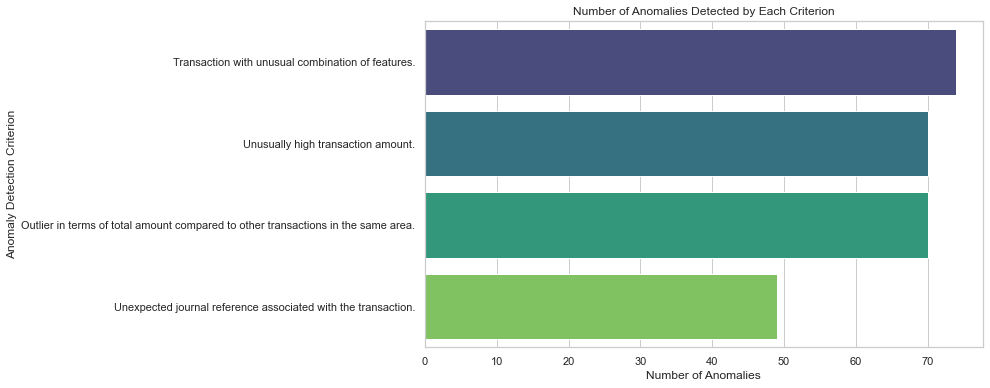

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Counting the number of anomalies for each comment
anomaly_counts = anomalous_transactions['Comment'].value_counts()

# Plotting the number of anomalies for each comment
plt.figure(figsize=(10, 6))
sns.barplot(x=anomaly_counts.values, y=anomaly_counts.index, palette='viridis')

plt.title('Number of Anomalies Detected by Each Criterion')
plt.xlabel('Number of Anomalies')
plt.ylabel('Anomaly Detection Criterion')
plt.show()


262 transcations have been identified as a outlier or anamolies. They Unusually high transaction amount, Transaction with unusual combination of features. if the Journal date is outside expected range ,Unexpected journal reference associated with the transaction, and any Outlier in terms of total amount compared to other transactions in the same area. 

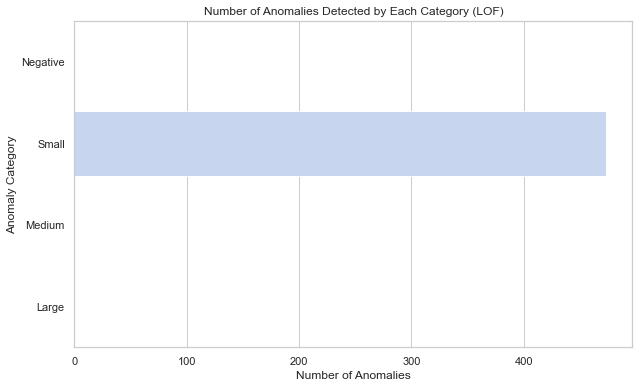

In [70]:
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'data' is your DataFrame containing the transaction data and 'anomalous_transactions' contains anomalies from Isolation Forest

# Fit Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_pred = lof.fit_predict(data[['Total']])

# Identify LOF anomalies
lof_anomalies = data[lof_pred == -1]
lof_anomalies['Detection Method'] = 'LOF'

# If you want to add custom comments or categories, you can do it here
# For example, categorize based on the 'Total' column
lof_anomalies['Category'] = pd.cut(lof_anomalies['Total'],
                                    bins=[-np.inf, 0, 1000, 10000, np.inf],
                                    labels=['Negative', 'Small', 'Medium', 'Large'])

# Count the number of anomalies in each category
lof_anomaly_counts = lof_anomalies['Category'].value_counts()

# Plotting the number of anomalies for each category in the LOF results
plt.figure(figsize=(10, 6))
sns.barplot(x=lof_anomaly_counts.values, y=lof_anomaly_counts.index, palette='coolwarm')

plt.title('Number of Anomalies Detected by Each Category (LOF)')
plt.xlabel('Number of Anomalies')
plt.ylabel('Anomaly Category')
plt.show()


Both models are valid, but they focus on different aspects of the data's distribution to identify anomalies. The larger number it simply means that LOF found additional anomalies not identified by the Isolation Forest. The key is understanding these differences and leveraging the strengths of each model for comprehensive anomaly detection.